In [1]:
import torch
import torch.optim as optim
from signalsurface.signal import *
from tqdm import tqdm
import open3d as o3d
import tifffile as tiff
import os
import glob
import igl
from matplotlib import pyplot as plt
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
mesh = o3d.io.read_triangle_mesh("20231205141500/20231205141500.obj")
V = np.asarray(mesh.vertices)
N = np.asarray(mesh.vertex_normals)
UV = np.asarray(mesh.triangle_uvs)  # Ensure your mesh has UV coordinates
F = np.asarray(mesh.triangles)
UV[:,0] *= 9040 # multiply by the right dimension
UV[:,1] *= 1925
uv = np.zeros((V.shape[0], 2), dtype=np.float64)
uvs = UV.reshape((F.shape[0], F.shape[1], 2))

for t in range(F.shape[0]):
    for v in range(F.shape[1]):
        uv[F[t,v]] = uvs[t,v]
uvs.shape
print(uvs[0])

[[2317.31357336   95.4264842 ]
 [2333.52226734  103.69185442]
 [2347.08236217   92.01115053]]


In [3]:
Vr = np.round(V).astype(np.uint16)
vertices = Vr[F]
q = np.zeros(Vr.shape[0])

In [4]:
needed_cubes = set()
for i in tqdm(range(Vr.shape[0])):
    x, y, z = Vr[i]
    x_cell = x//500 + 1
    y_cell = y//500 + 1
    z_cell = z//500 + 1
    needed_cubes.add((y_cell,x_cell,z_cell))

100%|██████████| 50426/50426 [00:00<00:00, 234186.70it/s]


In [6]:
cube_dict = {item: [] for item in needed_cubes}
for i in tqdm(range(Vr.shape[0])):
    x, y, z = Vr[i]
    x_cell = x//500 + 1
    y_cell = y//500 + 1
    z_cell = z//500 + 1

    x_coord = x%500
    y_coord = y%500
    z_coord = z%500
    cube_dict[(y_cell,x_cell,z_cell)].append([i,z_coord,y_coord,x_coord])

  0%|          | 0/50426 [00:00<?, ?it/s]

100%|██████████| 50426/50426 [00:00<00:00, 122125.30it/s]


In [7]:
for key, values in tqdm(cube_dict.items()):
    y_cell, x_cell, z_cell = key
    with tiff.TiffFile(f"D:/vesuvius/Scroll1.volpkg/volume_grids/20230205180739/cell_yxz_{y_cell:03d}_{x_cell:03d}_{z_cell:03d}.tif") as img:
        img = img.asarray()
        for element in values:
            q[element[0]] = img[element[1],element[2],element[3]]

    




100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


In [ ]:
q.shape

(649608,)

In [8]:
q_faces = np.zeros((F.shape[0],3))
for i in tqdm(range(F.shape[0])):
    for t in range(3):
        q_faces[i,t] = q[F[i,t]]

100%|██████████| 99740/99740 [00:00<00:00, 876741.59it/s]


In [9]:
q_f_torch = torch.from_numpy(q_faces)

In [11]:

p_torch = torch.from_numpy(uv).detach().requires_grad_(True)
vertices = torch.from_numpy(V)
faces = torch.from_numpy(F)
optimizer = optim.AdamW([p_torch], lr=0.01)  # or any other optimizer and learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [12]:
energies = []
for iteration in range(2000):  # or another convergence condition
    optimizer.zero_grad()  # Reset gradients
    en = energy(p_torch, q_f_torch, faces)  # Compute current energ
    en.backward()  # Compute gradients
    #print(x.grad, torch.any(torch.isnan(x.grad)))
    torch.nn.utils.clip_grad_norm_(p_torch.grad, max_norm=1.0)
    #print(x.grad)
    optimizer.step()  # Update positions
    scheduler.step()
    #x_old = x.clone().detach().requires_grad_(False)
    if iteration % 100 == 0:  # Periodically check convergence or log progress
        print(f'Iteration {iteration}, Energy: {en.item()}')
        energies.append(en.item())

Iteration 0, Energy: 13810606775841.2
Iteration 100, Energy: 12897481644243.771
Iteration 200, Energy: 12613647904825.98
Iteration 300, Energy: 12513884368282.559
Iteration 400, Energy: 12477566925083.332
Iteration 500, Energy: 12464213334036.95
Iteration 600, Energy: 12459293312185.188
Iteration 700, Energy: 12457481259554.367
Iteration 800, Energy: 12456814512077.07
Iteration 900, Energy: 12456569412585.338
Iteration 1000, Energy: 12456479383916.895
Iteration 1100, Energy: 12456446335767.541
Iteration 1200, Energy: 12456434210257.617
Iteration 1300, Energy: 12456429763076.66
Iteration 1400, Energy: 12456428132520.064
Iteration 1500, Energy: 12456427534825.572
Iteration 1600, Energy: 12456427315779.809
Iteration 1700, Energy: 12456427235516.324
Iteration 1800, Energy: 12456427206110.027
Iteration 1900, Energy: 12456427195337.77


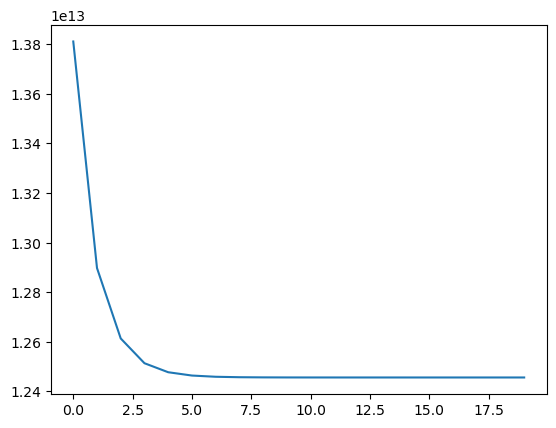

In [13]:
plt.plot(energies)

In [14]:
pt_view = p_torch.view(-1,2).clone().detach().numpy()

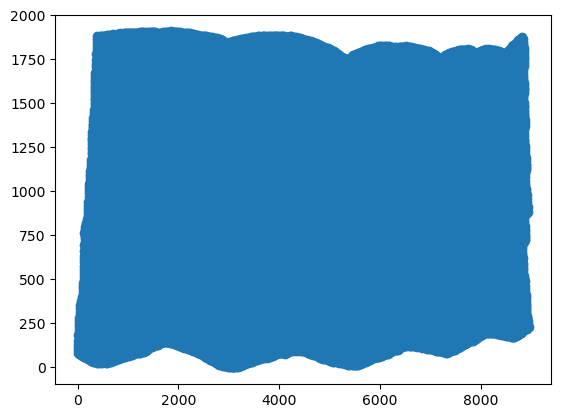

In [15]:
plt.scatter(pt_view[:,0], pt_view[:,1])

In [16]:
uvs_ssp = np.zeros_like(uvs)
for i in range(F.shape[0]):
    for t in range(F.shape[1]):
        uvs_ssp[i,t] = pt_view[F[i,t]]
uvs_ssp = uvs_ssp.reshape(-1,2)

In [22]:
uvs_ssp[0]

array([2295.23952826,   93.49519712])

In [48]:
np.allclose(uvs,pt_view.reshape(-1,3,2))

False

In [23]:
uv_max = np.max(uvs_ssp, axis=0)
uv_min = np.min(uvs_ssp, axis=0)




In [24]:
size_uvs = np.ceil(uv_max-uv_min)

In [25]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [26]:
image_path = "20231205141500/20231205141500_ssp.png"
# Create a white image of the determined size
image_size = (int(size_uvs[0]), int(size_uvs[1]))
white_image = np.ones((image_size[1], image_size[0]), dtype=np.uint16) * 65535

# Save the grayscale image
Image.fromarray(white_image, mode='L').save(image_path)

In [27]:
uvs_ssp -= uv_min
uvs_ssp /= (uv_max-uv_min)

In [28]:
mesh.triangle_uvs = o3d.utility.Vector2dVector(uvs_ssp)

In [29]:
o3d.io.write_triangle_mesh('20231205141500/20231205141500_ssp.obj', mesh)

[Open3D WARNING] Write PNG failed: image has no data.
[Open3D WARNING] Write OBJ successful, but failed to write texture file.


True

In [33]:
UV.shape

(299220, 2)

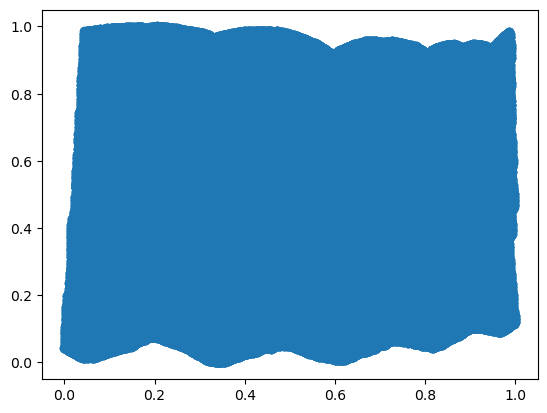

In [31]:
plt.scatter(uvs_ssp[:,0], uvs_ssp[:,1])

In [117]:
### SLIMMING
mesh = o3d.io.read_triangle_mesh("20231205141500/20231205141500.obj")
V = np.asarray(mesh.vertices)
N = np.asarray(mesh.vertex_normals)
UV = np.asarray(mesh.triangle_uvs)  # Ensure your mesh has UV coordinates
F = np.asarray(mesh.triangles)
_, _, F_int = igl.intrinsic_delaunay_cotmatrix(V, F) # compute intrinsic delaunay triangulation
#F_int = F


In [144]:
bnd = igl.boundary_loop(F_int)
bnd_uv = igl.map_vertices_to_circle(V, bnd)
uv_init = igl.harmonic(V, F_int, bnd, bnd_uv, 1)
bnd_uv = np.zeros((bnd.shape[0], 2), dtype=np.float64)

for i in range(bnd.shape[0]):
     bnd_uv[i] = uv_init[bnd[i]]

In [119]:
slim = igl.SLIM(V, F_int, v_init=uv_init, b=bnd, bc=bnd_uv, energy_type=igl.SLIM_ENERGY_TYPE_SYMMETRIC_DIRICHLET, soft_penalty=0)

In [120]:
threshold = 1e-5
converged = False
iteration = 0
while (not converged) and (iteration < 20000):
    print(iteration)
    temp_energy = slim.energy()
    slim.solve(1)
    new_energy = slim.energy()
    iteration += 1
    print(f"{temp_energy:.3f} {new_energy:.3f}")
    if new_energy >= float("inf") or new_energy == float("nan") or np.isnan(new_energy) or np.isinf(new_energy):
        continue
    elif new_energy < temp_energy:
        if abs(new_energy - temp_energy) < threshold:
            converged = True
        else:
            converged = False
    else:
        converged = True

0
131322918.814 38169883.413
1
38169883.413 7409326.589
2
7409326.589 2060192.454
3
2060192.454 316288.681
4
316288.681 9510.864
5
9510.864 1829.404
6
1829.404 148.794
7
148.794 42.085
8
42.085 12.686
9
12.686 9.718
10
9.718 8.201
11
8.201 8.120
12
8.120 8.062
13
8.062 8.055
14
8.055 8.054
15
8.054 8.050
16
8.050 8.049
17
8.049 8.049
18
8.049 8.048
19
8.048 8.048
20
8.048 8.048
21
8.048 8.048
22
8.048 8.047
23
8.047 8.047
24
8.047 8.047
25
8.047 8.047
26
8.047 8.047
27
8.047 8.047
28
8.047 8.047
29
8.047 8.047
30
8.047 8.047
31
8.047 8.047
32
8.047 8.047


In [121]:
def orient_uvs(vertices):
        # Rotate vertices and calculate the needed area
        vertices[:, 0] = 1.0 - vertices[:, 0]
        u_range = np.max(vertices[:, 0]) - np.min(vertices[:, 0])
        v_range = np.max(vertices[:, 1]) - np.min(vertices[:, 1])
        u_longer_v = u_range > v_range
        u_return = vertices[:, 0]
        v_return = vertices[:, 1]
        area_return = u_range * v_range
        for angle in range(-70, 70, 5):
            u_prime = vertices[:, 0] * np.cos(np.deg2rad(angle)) - vertices[:, 1] * np.sin(np.deg2rad(angle))
            v_prime = vertices[:, 0] * np.sin(np.deg2rad(angle)) + vertices[:, 1] * np.cos(np.deg2rad(angle))
            u_prime_range = np.max(u_prime) - np.min(u_prime)
            v_prime_range = np.max(v_prime) - np.min(v_prime)
            if u_prime_range < v_prime_range and u_longer_v:
                continue
            elif u_prime_range > v_prime_range and not u_longer_v:
                continue
            area = u_prime_range * v_prime_range
            if area < area_return:
                u_return = u_prime
                v_return = v_prime
                area_return = area
        return np.stack((u_return, v_return), axis=-1) 

In [122]:
oriented_uvs = orient_uvs(slim.vertices())

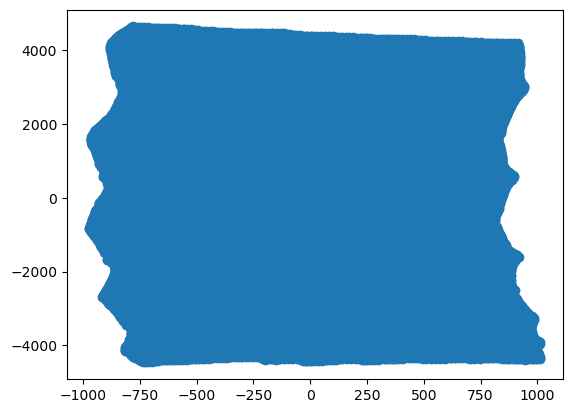

In [123]:
plt.scatter(oriented_uvs[:,0],oriented_uvs[:,1])

In [124]:
uv_max = np.max(oriented_uvs, axis=0)
uv_min = np.min(oriented_uvs, axis=0)
size_uvs = np.ceil(uv_max-uv_min)

In [125]:
size_uvs

array([1985., 9108.])

In [126]:
image_path = "20231205141500/20231205141500_id_slim.png"
# Create a white image of the determined size
image_size = (int(size_uvs[0]), int(size_uvs[1]))
white_image = np.ones((image_size[1], image_size[0]), dtype=np.uint16) * 65535

# Save the grayscale image
Image.fromarray(white_image, mode='L').save(image_path)

In [127]:
oriented_uvs -= uv_min
oriented_uvs /= (uv_max-uv_min)

In [128]:
uvs_slim = np.zeros((F_int.shape[0],3,2),dtype=np.float64)
for i in range(F_int.shape[0]):
    for t in range(3):
        uvs_slim[i,t] = oriented_uvs[F_int[i,t]]
uvs_slim = uvs_slim.reshape(-1,2)

In [129]:
mesh.triangles = o3d.utility.Vector3iVector(F_int)
mesh.triangle_uvs = o3d.utility.Vector2dVector(uvs_slim)

In [130]:
o3d.io.write_triangle_mesh('20231205141500/20231205141500_id_slim.obj', mesh)

[Open3D WARNING] Write PNG failed: image has no data.
[Open3D WARNING] Write OBJ successful, but failed to write texture file.


True

In [98]:
np.max(uvs_slim, axis=0)

array([9030.24226479, 1968.16160802])

In [132]:
### slim_ssp
mesh = o3d.io.read_triangle_mesh("20231205141500/20231205141500_id_slim.obj")
V = np.asarray(mesh.vertices)
N = np.asarray(mesh.vertex_normals)
UV = np.asarray(mesh.triangle_uvs)  # Ensure your mesh has UV coordinates
F = np.asarray(mesh.triangles)
UV[:,0] *= 1985 # multiply by the .png dimension
UV[:,1] *= 9108
uv = np.zeros((V.shape[0], 2), dtype=np.float64)
uvs = UV.reshape((F.shape[0], F.shape[1], 2))
for t in range(F.shape[0]):
    for v in range(F.shape[1]):
        uv[F[t,v]] = uvs[t,v]

In [133]:
q_faces = np.zeros((F.shape[0],3))
for i in tqdm(range(F.shape[0])):
    for t in range(3):
        q_faces[i,t] = q[F[i,t]]

q_f_torch = torch.from_numpy(q_faces)

#test = torch.from_numpy(test)
#p_torch = torch.from_numpy(uvs).detach().requires_grad_(True)
p_torch = torch.from_numpy(uv).detach().requires_grad_(True)
vertices = torch.from_numpy(V)
faces = torch.from_numpy(F)
optimizer = optim.AdamW([p_torch], lr=0.01)  # or any other optimizer and learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

100%|██████████| 99740/99740 [00:00<00:00, 563022.62it/s]


In [134]:
energies = []
for iteration in range(2000):  # or another convergence condition
    optimizer.zero_grad()  # Reset gradients
    en = energy(p_torch, q_f_torch, faces)  # Compute current energ
    en.backward()  # Compute gradients
    #print(x.grad, torch.any(torch.isnan(x.grad)))
    torch.nn.utils.clip_grad_norm_(p_torch.grad, max_norm=1.0)
    #print(x.grad)
    optimizer.step()  # Update positions
    scheduler.step()
    #x_old = x.clone().detach().requires_grad_(False)
    if iteration % 100 == 0:  # Periodically check convergence or log progress
        print(f'Iteration {iteration}, Energy: {en.item()}')
        energies.append(en.item())

Iteration 0, Energy: 13822793321968.512
Iteration 100, Energy: 12919257224319.08
Iteration 200, Energy: 12637124446764.107
Iteration 300, Energy: 12537877725738.387
Iteration 400, Energy: 12501743841959.89
Iteration 500, Energy: 12488458704579.414
Iteration 600, Energy: 12483564511003.523
Iteration 700, Energy: 12481762198523.633
Iteration 800, Energy: 12481099110130.766
Iteration 900, Energy: 12480855379553.086
Iteration 1000, Energy: 12480765861162.371
Iteration 1100, Energy: 12480733002662.156
Iteration 1200, Energy: 12480720947469.525
Iteration 1300, Energy: 12480716526310.754
Iteration 1400, Energy: 12480714905369.281
Iteration 1500, Energy: 12480714311223.012
Iteration 1600, Energy: 12480714093485.281
Iteration 1700, Energy: 12480714013703.59
Iteration 1800, Energy: 12480713984474.607
Iteration 1900, Energy: 12480713973767.543


In [135]:
pt_view = p_torch.view(-1,2).clone().detach().numpy()

In [137]:
uvs_slim_ssp = np.zeros((F.shape[0],3,2), dtype=np.float64)
for i in range(F.shape[0]):
    for t in range(F.shape[1]):
        uvs_slim_ssp[i,t] = pt_view[F[i,t]]
uvs_slim_ssp = uvs_slim_ssp.reshape(-1,2)

In [138]:
uvs_slim_ssp

array([[ 106.93905679, 6756.61577893],
       [ 115.20071667, 6743.33126371],
       [ 106.19237152, 6730.18958301],
       ...,
       [1865.78324878, 8249.49429   ],
       [1875.84454472, 8261.48764367],
       [1874.05970707, 8233.99255153]])

In [139]:
uv_max = np.max(uvs_slim_ssp, axis=0)
uv_min = np.min(uvs_slim_ssp, axis=0)
size_uvs = np.ceil(uv_max-uv_min)

In [140]:
image_path = "20231205141500/20231205141500_id_slim_ssp.png"
# Create a white image of the determined size
image_size = (int(size_uvs[0]), int(size_uvs[1]))
white_image = np.ones((image_size[1], image_size[0]), dtype=np.uint16) * 65535

# Save the grayscale image
Image.fromarray(white_image, mode='L').save(image_path)

In [141]:
uvs_slim_ssp -= uv_min
uvs_slim_ssp /= (uv_max-uv_min)

In [142]:
mesh.triangles = o3d.utility.Vector3iVector(F)
mesh.triangle_uvs = o3d.utility.Vector2dVector(uvs_slim_ssp)

In [145]:
uvs_slim_ssp

array([[0.05468558, 0.74939928],
       [0.05888627, 0.74792605],
       [0.05430592, 0.74646867],
       ...,
       [0.94898001, 0.91495661],
       [0.95409574, 0.91628664],
       [0.95318823, 0.91323749]])

In [146]:
o3d.io.write_triangle_mesh('20231205141500/20231205141500_id_slim_ssp.obj', mesh)

[Open3D WARNING] Write PNG failed: image has no data.
[Open3D WARNING] Write OBJ successful, but failed to write texture file.


True

In [113]:
size_uvs

array([1969., 9031.])

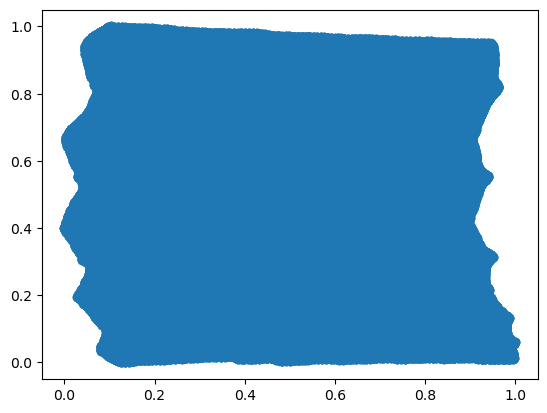

In [114]:
plt.scatter(uvs_slim_ssp[:,0], uvs_slim_ssp[:,1])